### NLP

**Sentiment Analysis**
Textblob, Vader - python implementations 


#### Text Handling

In [ ]:
import re 
import nltk 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from pprint import pprint

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
Doc_Dresses = ''

for description in df1['listing_description'].loc[df1['category']== 'Dresses & Skirts'] :
    
  Doc_Dresses += description
# Similarly for shoes, handbags, jewelry etc..
## THen 
data = [Doc_Dresses, Doc_Tops, Doc_Shoes, Doc_Handbags, Doc_Jewelry]

In [ ]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', desc) for desc in data]
# Remove new line characters
data = [re.sub('\s+', ' ', desc) for desc in data]
# Remove distracting single quotes
data = [re.sub("\'", "", desc) for desc in data]

In [ ]:
def tokenize_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [ ]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent[0:80000])) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        doc = nlp(" ".join(sent[80000:]))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    k = len(texts)    
    for i in range(0,2*k,2):
        texts_out[int(i/2)] = texts_out[i] + texts_out[i+1]
    del(texts_out[k:])    
    return texts_out

In [ ]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [ ]:
data_tokenized = list(tokenize_to_words(data)) 

In [ ]:
# Removing Stop words
data_tokenized_nostops = remove_stopwords(data_tokenized)

In [ ]:
# Lemmatizing the words in the data
data_lemmatized = lemmatization(data_tokenized_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
# Creating Dictionary and Corpus needed for LDA

id2word = corpora.Dictionary(data_lemmatized)

texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Compute Coherence Score for LDA Gensim Model
coherence_model_ldamallet = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

In [ ]:
# LDA Mallet model
mallet_path = '/Users/GArra/Downloads/mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
# Compute Coherence Score for LDA Mallet Model
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


In [252]:
## Find Dominant Topic in each document

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet_best, corpus=corpus, texts=data)
# Format
df_dominant_topic = df_topic_sents_keywords
df_dominant_topic.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic['Document_Name'] = ['Doc_Dresses', 'Doc_Tops', 'Doc_Shoes', 'Doc_Handbags', 'Doc_Jewelry' ]

# Show
df_dominant_topic.head(10)

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Document_Name
0,107.0,0.3404,"dress, skirt, fit, cute, wear, black, back, wa...",Short sleeve gray cotton dress with elastic co...,Doc_Dresses
1,109.0,0.3158,"wear, black, size, great, white, top, conditio...",Ivory long sleeve button up cardigan with lace...,Doc_Tops
2,84.0,0.3701,"wear, condition, worn, shoe, leather, great, b...","New without box, sexy brown Mary Janes, about ...",Doc_Shoes
3,102.0,0.4785,"bag, condition, leather, pocket, purse, strap,...",black big Buddha handbag. it has zippers and p...,Doc_Handbags
4,14.0,0.5681,"gold, bracelet, necklace, silver, earring, rin...",Gold Juicy Couture necklace...Bundle Jewelry h...,Doc_Jewelry


#### Word2Vec

In [32]:
from gensim.models import Word2Vec

In [33]:
model = Word2Vec(data_lemmatized, min_count = 1 )

In [34]:
words = list(model.wv.vocab)

In [35]:
print(len(words))

53455


In [36]:
print(model['archived'])

[-0.01304503  0.01342003  0.01932546  0.01090605 -0.00383949  0.0057388
 -0.00799574 -0.00652699 -0.00981121 -0.02238813  0.0085053  -0.00349492
  0.00754919 -0.03631161 -0.00754633 -0.00283785  0.01164345 -0.00776047
  0.0092297   0.00755661  0.00281078 -0.0286162  -0.00187311  0.02846198
  0.00235432 -0.00584758 -0.01063046 -0.01099445  0.01249471  0.00809554
  0.0056059  -0.01445068  0.00678791 -0.007005   -0.00275999  0.00454299
 -0.01059871 -0.00958562  0.00805073  0.00711019  0.0028041   0.00387333
  0.00494737 -0.00300251 -0.0068132  -0.0023617  -0.00135417 -0.01386133
 -0.00939176  0.00368123  0.00462883 -0.02452584  0.00873054  0.00473356
  0.02334513  0.01333403 -0.01005444  0.00386547 -0.00058445  0.01173749
  0.00519645  0.00626477  0.00829372  0.02498278  0.01056877  0.00196901
  0.00101545  0.00175311 -0.01906716 -0.00262955 -0.00474445 -0.00258271
 -0.00312935  0.00465701 -0.00022017 -0.00093548 -0.01116344 -0.0020957
 -0.00690459  0.00346498  0.01041238  0.00561128 -0.0

In [37]:
X = model[model.wv.vocab]

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
result = pca.fit_transform(X)

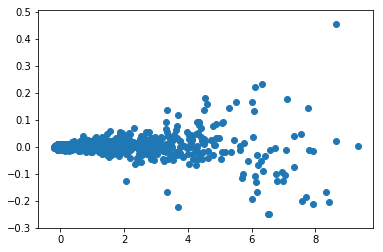

In [39]:
import matplotlib.pyplot as plt
plt.scatter(result[:, 0], result[:, 1])
#for i, word in enumerate(words):
	#plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

### Regression and Classification

#### Analyzing missing values

In [ ]:
listings.isnull().sum()

In [ ]:
col_acq_channel = df_cat.acq_channel.value_counts().nlargest(20).index.tolist()
df_cat.acq_channel = df_cat.acq_channel.apply(lambda x: x if x in col_acq_channel else 'other')
col_brand = df_cat.brand.value_counts().nlargest(20).index.tolist()
df_cat.brand = df_cat.brand.apply(lambda x: x if x in col_brand else 'other')
col_sub_category = df_cat.sub_category.value_counts().nlargest(20).index.tolist()
df_cat.sub_category = df_cat.sub_category.apply(lambda x: x if x in col_sub_category else 'other')
col_size = df_cat['size'].value_counts().nlargest(20).index.tolist()
df_cat['size'] = df_cat['size'].apply(lambda x: x if x in col_size else 'OS')

#### Feature Importances

In [ ]:
# Entire Dataset with log transformation
feature_imp = dict()
labels = X_inc.columns.tolist()
for i in range(0,len(labels)):
    feature_imp[labels[i]] = rfc_inc_cat.feature_importances_[i]
feature_imp = sorted(feature_imp.items(), key = lambda x : x[1], reverse = True) 
for i in range(0, len(labels)):
    #print (feature_imp[i][0], " \t \t \t", feature_imp[i][1])
    print('{0:>28} : {1:0.4f}'.format(feature_imp[i][0],feature_imp[i][1]))

#### Decile Chart

In [ ]:
prob = rfc2.predict_proba(X_test)
prob0 = [p[0] for p in prob]
prob1 = [p[1] for p in prob]
d = {'prob0': prob0,'prob1': prob1, 'true_ones': y_test,'pred_y':y_pred2,'listing_id': df.loc[df.d8to30manual_follows<=50].loc[X_test.index.tolist()]['listing_id']}
df5 = pd.DataFrame(data = d)
df5['rank'] = df5.sort_values(['prob1', 'listing_id'])['listing_id'].index + 1
df5['qcut'] = pd.qcut(df5['prob1'].rank(method = 'first'),10)
df5_group = df5.groupby(['qcut'])[['prob1', 'prob0', 'true_ones', 'pred_y']].sum().sort_values('true_ones', ascending = False)
df5_group['rmse'] = df5.groupby(['qcut']).apply(lambda x: mean_squared_error(x['true_ones'],x['prob1']))
df5_group['number'] = df5.groupby(['qcut']).apply(lambda x: len(x))
df5_group['true_zeros'] = df5_group['number'] - df5_group['true_ones']
df5_group['accuracy'] = df5.groupby(['qcut']).apply(lambda x: accuracy_score(x['true_ones'],x['pred_y']))
df5_group

#### Classification Stacked Model

In [ ]:
def avg_stack(models,meta_model,df):
    X = df.drop(['timetillsale','b_sold'],axis = 1)
    y = df.b_sold
    base_models = [list() for model in models]
    meta_model_ = clone(meta_model)
    kfold = KFold(n_splits= 5,shuffle= True, random_state= 36)
    out_of_fold_predictions = np.zeros((X.shape[0], len(base_models)))
    for i, model in enumerate(models):
        for train_index, valid_index in kfold.split(X,y):
            instance = clone(model)
            base_models[i].append(instance)
            instance.fit(X.loc[train_index],y.loc[train_index])
            y_pred = instance.predict(X.loc[valid_index])
            out_of_fold_predictions[valid_index,i] = y_pred
    meta_model.fit(out_of_fold_predictions,y)
    meta_features = np.column_stack([np.column_stack([model.predict(X) for model in models]).mean(axis = 1)
                                    for models in base_models])
    print(accuracy_score(y,meta_model.predict(meta_features)))
    return (base_models, meta_model, meta_model.predict(meta_features), meta_features)

#### Q Cut

In [ ]:
def qcut(df,feature1,feature2):
    df5 = df.copy()
    df5['qcut'] = pd.qcut(df5[feature1],10,duplicates='drop')
    le = LabelEncoder()
    df5['quant_no'] = le.fit_transform(df5['qcut'])
    group_mean = df5.groupby('qcut')[feature2].mean()
    group_median = df5.groupby('qcut')[feature2].median()
    group_min = df5.groupby('qcut')[feature2].min()
    group_max = df5.groupby('qcut')[feature2].max()
    group_num = df5.groupby('qcut').apply(lambda x : x.shape[0])
    data = {'number': group_num,'mean':group_mean,'median':group_median,'min':group_min,
           'max':group_max}
    df5_group = pd.DataFrame(data)
    return df5_group

In [ ]:
d = df.loc[df.d8to30manual_follows<=50]
d['listingprice_qcut'] = pd.qcut(d['listing_price'],10,duplicates='drop')
pivot_table(d,values = 'b_sold', index = 'listingprice_qcut', aggfunc = [np.sum,(len)])

#### Classification model

In [ ]:
def classify(model,df):
    X = df.drop(['timetillsale','b_sold'], axis = 1)
    y = df.b_sold
    X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 295)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    print('{0: 0.5f} This is the accuracy on train_test_split'.format(acc))
    return model,y_test,y_pred

#### Handling Skewness in data

In [ ]:
# Get top 10 features with largest skewness
df_box.skew().nlargest(10)

In [ ]:
num_feat = df.describe().columns.tolist()
lamda = -1
for feat in num_feat:
    df_box[feat] = boxcox1p(df_box[feat], lamda)

In [ ]:
# Log Transformation also helps reduce skewness
df_box.timetillsale = np.log1p(df.timetillsale)

#### Create word vectors for sentences 

In [272]:
def makeFeatureVec(words, model, num_features):
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 1.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,nwords)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

 #### Correlation Graph

In [ ]:
# df dataframe
f,ax = plt.subplots(figsize = (12,9))
col = df.describe().columns.tolist()
correlation = df[col].corr(method='pearson')
col = correlation.nlargest(10, 'timetillsale').index
sns.set(font_scale=1.0)
heatmap = sns.heatmap(listings[col].corr(), cbar=True, annot=True, square=True, fmt='.2f', yticklabels=col.values, xticklabels=col.values)
plt.xticks(fontsize=14, rotation=70)
plt.yticks(fontsize=14)
plt.show()

correlation.nlargest(10, 'timetillsale')['timetillsale']

#### Regression Model

In [ ]:
def rms(model,df):
    X = df.drop('timetillsale', axis = 1)
    y = df.timetillsale
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 295)
    #scaler = RobustScaler().fit(X_train)
    #rescaled_X_train = scaler.transform(X_train)
    #rescaled_X_test = scaler.transform(X_test)

    model.fit(X_train, y_train)
    model_pred = model.predict(X_test)
    print("Entire df : RMS error on train test split in log(days)", math.sqrt(mean_squared_error(y_test, model_pred)))
    print("Entire df : RMS error on train test split in days", math.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(model_pred))),'\n')
    return model

In [ ]:
sns.distplot(rfr1_pred, hist=False,label= 'predicted')
sns.distplot(y_test, hist = False,label = 'True')
plt.title('Random Forest Regressor Predicted vs True Density Graph')

#### Regression Average Stacking Model

In [ ]:
def avg_stack(models,meta_model,df):
    X = df.drop('timetillsale',axis = 1)
    y = df.timetillsale
    base_models = [list() for model in models]
    meta_model_ = clone(meta_model)
    kfold = KFold(n_splits= 5,shuffle= True, random_state= 36)
    out_of_fold_predictions = np.zeros((X.shape[0], len(base_models)))
    for i, model in enumerate(models):
        for train_index, valid_index in kfold.split(X,y):
            instance = clone(model)
            base_models[i].append(instance)
            instance.fit(X.loc[train_index],y.loc[train_index])
            y_pred = instance.predict(X.loc[valid_index])
            out_of_fold_predictions[valid_index,i] = y_pred
    meta_model.fit(out_of_fold_predictions,y)
    meta_features = np.column_stack([np.column_stack([model.predict(X) for model in models]).mean(axis = 1)
                                    for models in base_models])
    print(math.sqrt(mean_squared_error(y,meta_model.predict(meta_features))))
    return base_models, meta_model, meta_model.predict(meta_features)

### EDA

In [2]:
library('ggplot2')
library('repr')
library('plyr')
library('ggthemes')
library('scales')

In [ ]:
df = read.csv('df.csv', header = TRUE)

In [ ]:
head(df)

In [ ]:
df$create_date = as.Date(df$create_date)
df$sold_date = as.Date(df$sold_date)

#### Histograms

In [ ]:
# Histogram of Timetillsale
options(repr.plot.width=6, repr.plot.height=3)
ggplot(aes(x = timetillsale, fill = gender), data = df) +
geom_histogram(breaks = seq(0,60,5), position = 'dodge') + 
scale_x_continuous(breaks = seq(0,60,5)) +
scale_y_continuous(breaks = seq(0,800000,50000))  +
scale_fill_solarized() +
theme_solarized(light = TRUE)+
xlab('timetillsale')+
ylab('count')+
ggtitle('Distribution of Timetillsale')+ 
theme(axis.text=element_text(size=10),axis.title=element_text(size=10),plot.title = element_text(size = 12, face = "bold"))

In [ ]:
brands = c('other','Nike', 'LuLaRoe', "Victoria's Secret", 'J. Crew', 'lululemon athletica', 'Coach',"PINK Victoria's Secret", "American Eagle Outfitters", "Old Navy","Michael Kors")
# Histogram of people according to Brand
options(repr.plot.width=16, repr.plot.height=10)
ggplot(aes(x = brand, fill = gender), data = df_brand_10) +
geom_bar(position = 'dodge')   +
scale_fill_solarized() +
theme_solarized(light = TRUE)+
scale_y_continuous(breaks = seq(0,100000,10000))+
xlab('Brands')+
ylab('count')+
ggtitle('Distribution of People according to Brand ')+ 
theme(axis.text=element_text(size=12),axis.title=element_text(size=20),plot.title = element_text(size = 24, face = "bold"))

print(paste(nrow(subset(df, brand == 'Nike' | brand == 'LuLaRoe' | brand == "Victoria's Secret" | brand == 'J. Crew' | brand == 'lululemon athletica'| brand == 'Coach' | brand =="PINK Victoria's Secret"| brand == "American Eagle Outfitters"|brand == "Old Navy"|brand == 'Michael Kors')), "number of people from top 10 brands out of ", nrow(df), 'population'))

In [ ]:
# Histogram of Listing Price
options(repr.plot.width=10, repr.plot.height=6)
ggplot(aes(x = listing_price/100, fill = gender), data = subset(df, listing_price/100 <= 100)) +
geom_histogram(breaks = seq(0,100,5), position = 'dodge') + 
scale_x_continuous(breaks = seq(0,100,5)) +
scale_y_continuous(breaks = seq(0,500000,50000))  +
scale_fill_solarized() +
theme_solarized(light = TRUE)+
xlab('listingprice')+
ylab('count')+
ggtitle('Distribution of listing price under 100$')+ 
theme(axis.text=element_text(size=10),axis.title=element_text(size=10),plot.title = element_text(size = 12, face = "bold"))

In [ ]:
# Histogram of Previous Items Bought
options(repr.plot.width=10, repr.plot.height=6)
ggplot(aes(x = prev_items_bought, fill = gender), data = subset(df, prev_items_bought < 100)) +
geom_histogram(breaks = seq(0,100,5)) + 
scale_x_continuous(breaks = seq(0,100,5)) +
scale_y_continuous(breaks = seq(0,700000,50000))  +
theme_solarized(light = TRUE)+
theme_hc(bgcolor = "darkunica") +
scale_fill_hc("darkunica")+
xlab('previous items bought')+
ylab('count')+
ggtitle('Distribution of Previous Items bought')+ 
theme(axis.text=element_text(size=10, color = 'red'),axis.title=element_text(size=10),plot.title = element_text(size = 12, face = "bold"))

#### Two Variable Graphs

In [ ]:
# Plot of d8to30 manual following vs Timetillsale
ggplot(df, aes(x=d8to30manual_following, y=timetillsale, color = department)) +
geom_point()  + 
geom_smooth(method.args= list(degree=1),span=0.75, color = 'Tomato') + 
facet_wrap(~(cut_number(listing_price/100, n = 5))) +
ylab("Time till sale") + xlab('Day 8 to 30 Manual Following')+
ggtitle('d8to30 manual following vs timetillsale')+
theme(axis.text=element_text(size=12),axis.title=element_text(size=14)) 
